In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from random import randint
%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, mean_y, std_y = standardize(weight)
y, tx = build_model_data(x, y)

# 1 Computing the Cost Function

Fill in the `compute_loss` function below:
<a id='compute_loss'></a>


In [3]:
def compute_loss_mse(y, tx, w):
    """Calculate the loss.
    
    You can calculate the loss using mse or mae.
    """
    # compute loss by MSE
    N = len(y)
    e = y - np.dot(tx, w)
    loss = .5 / N * np.linalg.norm(e, 2) ** 2
    return loss

In [4]:
def compute_loss_mae(y, tx, w):
    """Calculate the loss.
    
    You can calculate the loss using mse or mae.
    """
    # compute loss by MAE
    N = len(y)
    e = y - np.dot(tx, w)
    loss = 1 / N * np.sum(np.abs(e))
    return loss

In [5]:
a = compute_loss_mse(y, tx, np.array([1, 2]))
b = compute_loss_mae(y, tx, np.array([1, 2]))
a, b

(1.1504874025181688, 1.2370695869347874)

# 2 Grid Search

Fill in the function `grid_search()` below:

In [6]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = []
    # compute loss for each combination of w0 and w1.
    for w0_ in w0:
        for w1_ in w1:
            weights = np.array([w0_, w1_])
            losses += [compute_loss_mse(y, tx, weights)]
    
    return np.array([losses]).reshape((len(w0), len(w1)))

In [7]:
def grid_search_bis(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    # compute loss for each combination of w0 and w1.
    for i in range(len(w0)):
        for j in range(len(w1)):
            weights = np.array([w0[i], w1[j]])
            losses[i, j] = compute_loss_mse(y, tx, weights)
    return losses

In [8]:
from grid_search import generate_w
# compare execution speed between the two above functions
methods = [grid_search, grid_search_bis]
timer = []

grid_w0, grid_w1 = generate_w(num_intervals=20)

# Generate the grid of parameters to be swept
for f in methods:
    r = %timeit -o f(y, tx, grid_w0, grid_w1)
    timer += [r]
    print(end='\n\n')

11.6 ms ± 266 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


11.6 ms ± 265 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)




Let us play with the grid search demo now!

Grid Search: loss*=0.09275654763525835, w0*=-0.20040080160319462, w1*=0.9018036072144469, execution time=7.315 seconds


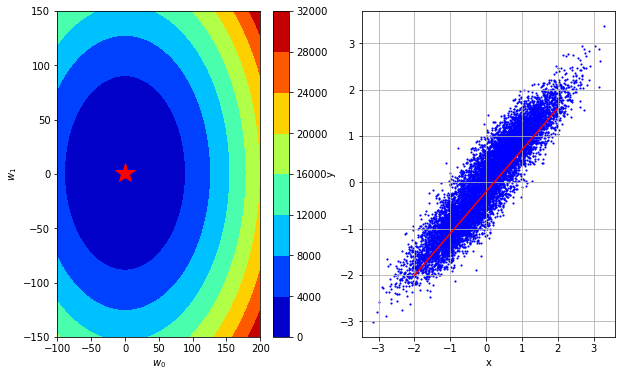

In [9]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=500)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search_bis(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, x, y)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# 3 Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [10]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    # compute gradient and loss
    e = y - np.dot(tx, w)
    N = len(y)
    gradient = - (1 / N) * np.dot(np.transpose(tx), e)
    return gradient


In [11]:
# check with an example if compute gradient works as expected
tx_test = np.array([[1, 2], [1, 4]])
y_test  = np.array([7, 5])
w_test  = np.array([1, 2])

compute_gradient(y_test, tx_test, w_test)

array([1., 6.])

In [12]:
np.sqrt(np.sum((np.array([1, 2]) - np.array([1, 6])) ** 2))

4.0

Please fill in the functions `gradient_descent` below:

In [67]:
from scipy.spatial.distance import cdist

def gradient_descent(y, tx, initial_w, max_iters, gamma, threshold=10**(-5)):
    """grad descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w_t = initial_w

    for n_iter in range(max_iters):
        # compute grad for the current iteration
        grad = compute_gradient(y, tx, w_t)
        # update rule
        w_t1 = w_t - gamma*grad
        # compute loss
        loss = compute_loss_mse(y, tx, w_t1)
        # update lists
        ws += [w_t1]
        losses += [loss]
        
#         print("grad Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
#               bi=n_iter, ti=max_iters - 1, l=loss, w0=w_t1[0], w1=w_t1[1]))
        
        # if consecutive gradient updates are really small
        # w(t+1) - w(t) < threshold
        # naive early stopping 
#         if np.sqrt(np.sum((w_t - w_t1) ** 2)) < threshold:
#             break

        # update current weight
        w_t = w_t1
    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [46]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 150
gamma = .05

# Initialization
w_initial = np.array([-50, -100])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

grad Descent(0/149): loss=86.6927846347635, w0=-47.50000000000001, w1=-94.95376218506296
grad Descent(1/149): loss=82.35876891367539, w0=-45.125000000000014, w1=-90.15983626087277
grad Descent(2/149): loss=78.24146005173016, w0=-42.86875000000002, w1=-85.60560663289208
grad Descent(3/149): loss=74.33003603413066, w0=-40.72531250000002, w1=-81.27908848631043
grad Descent(4/149): loss=70.61418386848905, w0=-38.68904687500003, w1=-77.16889624705787
grad Descent(5/149): loss=67.08412908243277, w0=-36.754594531250035, w1=-73.26421361976793
grad Descent(6/149): loss=63.73058924629554, w0=-34.916864804687535, w1=-69.55476512384249
grad Descent(7/149): loss=60.54474280985319, w0=-33.17102156445316, w1=-66.03078905271332
grad Descent(8/149): loss=57.51819908286132, w0=-31.51247048623051, w1=-62.6830117851406
grad Descent(9/149): loss=54.64298254221903, w0=-29.93684696191898, w1=-59.502623380946524
grad Descent(10/149): loss=51.91152682860887, w0=-28.440004613823035, w1=-56.48125439696216
grad D

In [47]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, x, y, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=151, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# 4 Stochastic Gradient Descent

In [202]:
from math import ceil
# from stochastic_gradient_descent import *
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    # number of samples
    N = len(y)
    # error vector
    e = y - np.dot(tx, w)
    # stochastic gradient
    stoch_grad = - np.dot(np.transpose(tx), e) / N
    return stoch_grad


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent algorithm."""
    losses = []
    ws = [initial_w]
    w  = initial_w
    
    for n_iter in range(max_iters):
        for batch_y, batch_tx in batch_iter(y, tx, batch_size, shuffle=True):
            # compute gradient
            g = compute_stoch_gradient(batch_y, batch_tx, w)
            # update rule
            w_t1 = w - gamma * g
            # compute loss
            loss = compute_loss_mse(batch_y, batch_tx, w_t1)
            # update lists
            losses += [loss]
            ws += [w_t1]
            
#             print("Stoch Grad Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
#               bi=n_iter, ti=max_iters - 1, l=loss, w0=w_t1[0], w1=w_t1[1]))
            
            # if consecutive gradient updates are really small
            # w(t+1) - w(t) < threshold
            # naive early stopping       
#             if np.sqrt(np.sum((w-w_t1)**2)) < threshold:
#                 break
            
            # update current w
            w = w_t1
            
    return losses, ws

def stochastic_gradient_descent_bis(y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent algorithm."""
    losses = []
    ws = [initial_w]
    w  = initial_w
    
    for n_iter in range(max_iters):
        n = np.random.randint(0, len(y))
        batch_y, batch_tx = y[[n]], tx[[n]]
        # compute gradient
        g = compute_stoch_gradient(batch_y, batch_tx, w)
        # update rule
        w_t1 = w - gamma * g
        # compute loss
        loss = compute_loss_mse(batch_y, batch_tx, w_t1)
        # update lists
        losses += [loss]
        ws += [w_t1]
            
#       print("Stoch Grad Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
#           bi=n_iter, ti=max_iters - 1, l=loss, w0=w_t1[0], w1=w_t1[1]))
            
            # if consecutive gradient updates are really small
            # w(t+1) - w(t) < threshold
            # naive early stopping       
#             if np.sqrt(np.sum((w-w_t1)**2)) < threshold:
#                 break
            
        # update current w
        w = w_t1
            
    return losses, ws

In [91]:
# Define the parameters of the algorithm.
max_iters = 150
gamma = 0.03
batch_size = 1

# Initialization
w_initial = np.array([150, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent_bis(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD: execution time=0.007 seconds


In [92]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, x, y, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=151, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

In [88]:
# compare execution time of Gradient Descent vs SGD

# Define the parameters of the algorithm.
max_iters = 150
gamma = .05
batch_size = 1

# Initialization
w_initial = np.array([150, 100])

methods = [gradient_descent, stochastic_gradient_descent, stochastic_gradient_descent_bis]
timer = []

for i, f in enumerate(methods):
    if i == 0:
        r = %timeit -o f(y, tx, w_initial, max_iters, gamma)
    else:
        r = %timeit -o f(y, tx, w_initial, batch_size, max_iters, gamma)
    timer += [r]
        

19.3 ms ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
50.6 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.04 ms ± 23 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# 5 Effect of Outliers and MAE Cost Function, and Subgradient Descent

### Exercise 5

Load and plot data containing outliers

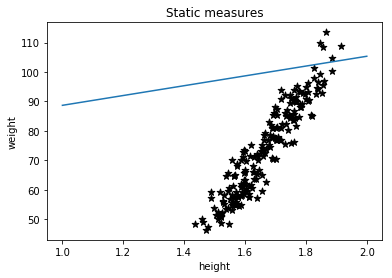

In [171]:
height, weight, gender = load_data(sub_sample=True, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

plt.scatter(height, weight, label='skitscat', color='k', marker='*', s=50)
plt.xlabel('height')
plt.ylabel('weight')
plt.title('Static measures')

# initial guess
initial_w = [2, 2]

# Define the parameters of the algorithm.
max_iters = 200
gamma = 0.7
batch_size = 1

losses, ws = stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma)
b, a = ws[len(ws)-1]

xs = np.array([1, 2])
ys = a*xs + b
plt.plot(xs, ys)
plt.show()

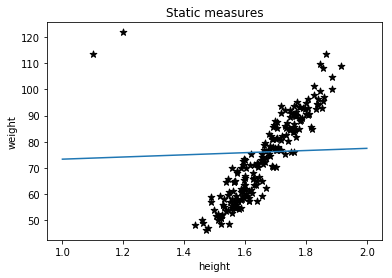

In [203]:
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

plt.scatter(height, weight, label='skitscat', color='k', marker='*', s=50)
plt.xlabel('height')
plt.ylabel('weight')
plt.title('Static measures')

# initial guess
initial_w = [200, 100]

# Define the parameters of the algorithm.
max_iters = 1000
gamma = 0.7
batch_size = 1

sgd_losses, sgd_ws = stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma)
# b = (sgd_ws[len(sgd_ws)-1
b, a = sgd_ws[len(sgd_ws)-1]

xs = np.array([1, 2])
ys = a*xs + b
plt.plot(xs, ys)
plt.show()

In [204]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, x, y, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=1001, min=1), Output()), _dom_classes=('wid…

<function __main__.plot_figure(n_iter)>

# Subgradient of the MAE

In [152]:
def compute_subgradient_mae_bis(y, tx, w):
    """Compute a subgradient."""
    N = len(y)
    dl_w = np.zeros((len(w),))
    
    for i in range(len(w)):
        dl_wi = 0
        for n in range(len(y)):
            e_n = y[n] - np.dot(tx[n], w)
            sign = 1 if e_n < 0 else -1
            dl_wi += sign*tx[n][i]
            
        dl_w[i] = dl_wi / N
    return dl_w.ravel()

In [151]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient."""
    N = len(y)
    e = y - np.dot(tx, w)
    
    return - np.dot(np.transpose(tx), np.sign(e)) / N

In [153]:
def compute_gradient_mae(y, tx, w):
    """Compute the gradient."""
    # compute gradient and loss
    # w is a non-differentiable point only
    # if the error vector contains the value zero
    
    # whether or not w is a non-differentiable point
    # the gradient computation remains the same as in
    # compute_subgradient_mae
    
    return compute_subgradient_mae(y, tx, w)

In [154]:
def compute_stoch_gradient_mae(y, tx, w):
    """Compute the gradient."""
    # compute gradient and loss
    # w is a non-differentiable point only
    # if the error vector contains the value zero
    
    # whether or not w is a non-differentiable point
    # the gradient computation remains the same as in
    # compute_subgradient_mae
    
    return compute_subgradient_mae(y, tx, w)

In [161]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent algorithm."""
    losses = []
    ws = [initial_w]
    w  = initial_w
    
    for n_iter in range(max_iters):
        for batch_y, batch_tx in batch_iter(y, tx, batch_size, shuffle=True):
            # compute gradient
            g = compute_stoch_gradient_mae(batch_y, batch_tx, w)
            # update rule
            w_t1 = w - gamma * g
            # compute loss
            loss = compute_loss_mae(batch_y, batch_tx, w_t1)
            # update lists
            losses += [loss]
            ws += [w_t1]
            
#             print("Stoch Grad Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
#               bi=n_iter, ti=max_iters - 1, l=loss, w0=w_t1[0], w1=w_t1[1]))
            
            # if consecutive gradient updates are really small
            # w(t+1) - w(t) < threshold
            # naive early stopping       
#             if np.sqrt(np.sum((w-w_t1)**2)) < threshold:
#                 break
            
            # update current w
            w = w_t1
            
    return losses, ws


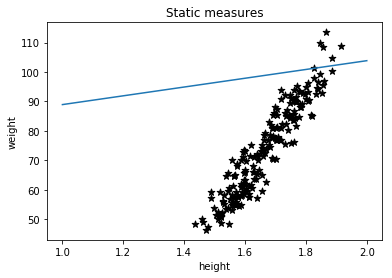

In [196]:
height, weight, gender = load_data(sub_sample=True, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

plt.scatter(height, weight, label='skitscat', color='k', marker='*', s=50)
plt.xlabel('height')
plt.ylabel('weight')
plt.title('Static measures')

# initial guess
initial_w = [200, 100]

# Define the parameters of the algorithm.
max_iters = 1000
gamma = 0.7
batch_size = 1

sub_sgd_losses, sub_sgd_ws = stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma)
b, a = sub_sgd_ws[len(sub_sgd_ws)-1]

xs = np.array([1, 2])
ys = a*xs + b
plt.plot(xs, ys)
plt.show()

In [187]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sub_sgd_losses, sub_sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, x, y, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sub_sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=1001, min=1), Output()), _dom_classes=('wid…

<function __main__.plot_figure(n_iter)>

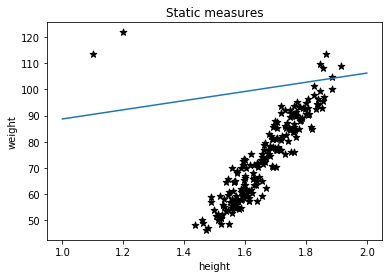

In [188]:
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

plt.scatter(height, weight, label='skitscat', color='k', marker='*', s=50)
plt.xlabel('height')
plt.ylabel('weight')
plt.title('Static measures')

# initial guess
initial_w = [200, 100]

# Define the parameters of the algorithm.
max_iters = 1000
gamma = 0.7
batch_size = 1

sub_sgd_losses, sub_sgd_ws = stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma)
b, a = sub_sgd_ws[len(sub_sgd_ws)-1]

xs = np.array([1, 2])
ys = a*xs + b
plt.plot(xs, ys)
plt.show()

In [189]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sub_sgd_losses, sub_sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, x, y, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sub_sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=1001, min=1), Output()), _dom_classes=('wid…

<function __main__.plot_figure(n_iter)>